# Understanding Statistical Modeling

In this notebook, I lay out some of the basic principles behind a set of techniques that have taken off in digital humanities, data science, and a wide variety of relatied fields. These techniques are usually named by a set of umbrella terms---statistical modeling, machine learning, even "artificial intelligence." In a nutshell, these approaches take a large dataset and attempt to determine values or categories from that data. I'll show a few of the most basic versions of this approach and gesture to more complex methods. 

Modeling, writ large, has become a massive field in data science. Ted Underwood uses models to understand literary history in *Distant Horizons*, the OCR tool Ocular uses statistical models of both typefaces and language, and, of course, topic modeling was one of the earliest types of modeling to be widely adopted by humanities scholars. But statistical models are also often what is underneath the vague talk of "algorithms" or "machine learning" that make up so much discussion of contemporary technology. Models help to deliver search results, determine what social media posts you see, and [even try to predict who will be elected president](https://projects.fivethirtyeight.com/2020-election-forecast/). Understanding how statistical modeling works can help you to critique the technologies that increasingly determine so much of our lives, and it can help you to better understand the recent achievements of statistical models in the humanities (and even use these techniques in your own work).

*This is a Jupyter Notebook, which allows me to show code and the results of that code together with written text. My purpose here is not to teach you how to code but to demonstrate how this work can be done with Python while providing explanations of how statistical modeling is done from beginning to end. In Python, you begin by `import`ing libraries and functions that you'll need to write your script. Most of functions and methods for this process come from the very detailed Python machine learning library [scikit-learn](https://scikit-learn.org/stable/index.html).*

In [1]:
# General Libraries Needed
import glob, csv
import pandas as pd
from collections import defaultdict
import numpy as np

# Functions for Unsupervised Clustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer

# Functions for Supervised Classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

# Libraries for Graphing
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

## Reading a Text Corpus

You can create a statistical model from any kind of data, but in this exercise we'll use data derived from a set of text files, a corpus of literary works. Here we're borrowing techniques from the field of *information retrieval*. Many machine learning tutorials begin with data already prepared, but it's more helpful to see how this works from the very beginning. What happens when you have a bunch of text files and want to build a model based on their wordcounts?

In this example, we're using [the complete works of Shakespeare from the Folger Shakespeare Library](https://shakespeare.folger.edu/download-the-folger-shakespeare-complete-set/). This corpus is commonly used because the texts are readily available, and there's a ready-made set of genre labels to use as examples. However, I'm very aware of the problems inherent in repeatedly using Shakespeare as the main example in DH projects. Not only have I written on this topic myself, I endorse Laura Estill's assessment of ["Digital Humanities' Shakespeare Problem"](https://doi.org/10.3390/h8010045). However, for the purposes of pedagogy rather than a public-facing study, the Shakespeare corpus gives us a stable set of texts that we can talk about quickly. As you look through the examples, it's worth thinking about what a non-Shakespeare example might look like and what using Shakespeare as our example does to our results.

We begin by loading in a set of a plain text files. I keep these in a directory named `shakespeare`, and each file's name is the title of a play. (The Folger corpus includes Shakespeare's sonnets and other poetry, but I've not included those files in this example.) As you can see when we `print` the first part of the first file, these are just plaintext files of the plays without any adjustment. I haven't even removed the copyright information, because as we'll see, small differences in wording are less important to the model than big trends, and some differences are smoothed out by our choice of method.

In [2]:
files = glob.glob("shakespeare/*.txt") # Get files from shakespeare directory
filenames = [f.split("/")[1].split("_")[0] for f in files] # Keep titles of plays for later

# Open all files and store their text
texts = []
for f in files:
    with open(f, 'r') as readfile:
        texts.append(readfile.read())
        
# Print the first 1000 characters of the first file (Coriolanus)
print(texts[0][:1000])

Coriolanus
by William Shakespeare
Edited by Barbara A. Mowat and Paul Werstine
  with Michael Poston and Rebecca Niles
Folger Shakespeare Library
https://shakespeare.folger.edu/shakespeares-works/coriolanus/
Created on May 11, 2016, from FDT version 0.9.2.1

Characters in the Play
Caius MARTIUS, later Caius Martius CORIOLANUS
VOLUMNIA, his mother
VIRGILIA, his wife
YOUNG MARTIUS, their son
VALERIA, friend to Volumnia and Virgilia
A GENTLEWOMAN, Volumnia's attendant
MENENIUS Agrippa, patrician
COMINIUS, patrician and general
Titus LARTIUS, patrician and military officer
SICINIUS Velutus, tribune
Junius BRUTUS, tribune
Roman SENATORS, PATRICIANS, NOBLES
Roman LIEUTENANT
Roman OFFICERS
Roman AEDILES
Roman HERALD
Roman SOLDIERS
Roman CITIZENS or PLEBEIANS
Roman MESSENGERS
A ROMAN defector, Nicanor
Tullus AUFIDIUS, general of the Volscians
Volscian CONSPIRATORS of his faction
Three of his SERVINGMEN
Volscian SENATORS, LORDS
Volscian LIEUTENANT
Volscian SOLDIERS
Two of


## Getting Word Counts

The next step is to count every word in every play. The sklearn method `CountVectorizer()` lets us do that easily. It even includes a predefined list of "stop words": very common English words like articles and pronouns that we often want to avoid. [n.b. For some purposes, like in authorship attributions, the most common words are the *most* informative and shouldn't be left out.]

Once `CountVectorizer()` does its work, the output (which I've cleaned up using [pandas](https://pandas.pydata.org/)) is a *matrix* or table of results. In this matrix, each row is a *sample* or distinct object that we want to study, in this case a play. Each column is a *feature*, or the attributes of the samples that we care about, in this case words. The *value* of every cell in the matrix tells us the number of times that word appears in that text. This format, of a *feature space* or matrix of information, is fundamental to how machine learning works. For more on matrices and features spaces, refer to [my Programming Historian tutorial on text similarity](https://programminghistorian.org/en/lessons/common-similarity-measures).

Features are also described as *dimensions*. Each column of our matrix could be graphed as the x- or y-axis of a Cartesian graph, and we could place our plays as datapoints on that graph based on how often they contain particular words. Here's an example (from the tutorial I linked to above) that graphs the first sentences of Edith Wharton's *Ethan Frome* and Jane Austen's *Pride and Prejudice* based on how often they use the article "a" and the pronoun "in":

![](datapoints.jpg)

In this way, every single *feature* of a sample can be expressed as a different *dimension*. In our case (and in most cases), we have thousands of dimensions: far more than the three that can be easily visualized. But matrices essentially deal with the same principles as two-dimensional graphs like the one above, but in many more dimensions.

In [3]:
vectorizer = CountVectorizer(min_df=.65, max_df=1.0, strip_accents="unicode", stop_words="english")
wordcounts = vectorizer.fit_transform(texts)
df = pd.DataFrame(wordcounts.toarray(), index=filenames, columns=vectorizer.get_feature_names())
df

,2015,31,able,abroad,absence,according,act,action,add,adieu,...,wrong,wrongs,yea,year,years,yes,yield,yonder,young,youth
coriolanus,0,0,2,0,4,1,9,13,0,2,...,2,2,4,1,5,7,7,2,11,2
julius-caesar,0,0,0,2,1,3,7,2,1,0,...,17,2,4,1,4,6,3,3,11,0
loves-labors-lost,1,1,0,2,1,0,5,1,2,9,...,5,0,3,5,14,7,3,1,4,5
antony-and-cleopatra,1,1,1,2,2,0,12,5,1,7,...,3,0,2,2,2,7,6,2,3,5
henry-viii,1,1,7,3,1,0,9,2,2,0,...,6,1,9,3,4,20,0,0,9,0
henry-v,1,1,1,2,2,3,8,4,2,3,...,3,2,3,5,3,7,7,3,2,8
troilus-and-cressida,0,0,1,1,1,0,12,9,3,4,...,7,0,10,1,1,5,2,13,12,10
the-winters-tale,0,0,2,3,5,1,8,1,1,2,...,2,1,7,3,9,2,1,0,13,6
king-john,0,0,0,3,1,1,13,5,3,3,...,8,4,3,3,1,1,2,0,23,3
timon-of-athens,1,1,2,1,1,0,6,0,1,0,...,4,4,3,1,0,9,4,2,5,6


However, we don't want to work with raw word counts! What if one play is much longer than another? Then the fact that the word "yes" appears much more wouldn't tell us much about the differences between the plays except their length. To deal with this, we want to work with *relative* values, and we can create these through a process called *normalization*. We could simply take relative frequences by dividing the raw word count by the total number of words in a text. But even better is to use *L2 Normalization*, which makes it so that the squares of all the values for a sample add up to 1. This is the most common kind of normalization used in informational retrieval for texts, and it helps to deal with the problem of *magnitude* (when results are skewed by one text being much longer than another).

Now let's create a new matrix with *normalized* values:

In [4]:
normalizer = Normalizer(norm='l2') #Create a Normalizer instance just like we did with the Vectorizer
norm_features = normalizer.fit_transform(wordcounts.toarray()) # Feed in our wordcounts

# Put into a pandas dataframe so we can view it
df_norm = df = pd.DataFrame(norm_features, index=filenames, columns=vectorizer.get_feature_names())
df_norm

,2015,31,able,abroad,absence,according,act,action,add,adieu,...,wrong,wrongs,yea,year,years,yes,yield,yonder,young,youth
coriolanus,0.000000,0.000000,0.004019,0.000000,0.008037,0.002009,0.018083,0.026121,0.000000,0.004019,...,0.004019,0.004019,0.008037,0.002009,0.010046,0.014065,0.014065,0.004019,0.022102,0.004019
julius-caesar,0.000000,0.000000,0.000000,0.005484,0.002742,0.008226,0.019194,0.005484,0.002742,0.000000,...,0.046615,0.005484,0.010968,0.002742,0.010968,0.016452,0.008226,0.008226,0.030162,0.000000
loves-labors-lost,0.002367,0.002367,0.000000,0.004734,0.002367,0.000000,0.011834,0.002367,0.004734,0.021301,...,0.011834,0.000000,0.007100,0.011834,0.033135,0.016568,0.007100,0.002367,0.009467,0.011834
antony-and-cleopatra,0.002000,0.002000,0.002000,0.004000,0.004000,0.000000,0.024001,0.010000,0.002000,0.014001,...,0.006000,0.000000,0.004000,0.004000,0.004000,0.014001,0.012001,0.004000,0.006000,0.010000
henry-viii,0.001966,0.001966,0.013760,0.005897,0.001966,0.000000,0.017691,0.003931,0.003931,0.000000,...,0.011794,0.001966,0.017691,0.005897,0.007863,0.039314,0.000000,0.000000,0.017691,0.000000
henry-v,0.002048,0.002048,0.002048,0.004095,0.004095,0.006143,0.016381,0.008190,0.004095,0.006143,...,0.006143,0.004095,0.006143,0.010238,0.006143,0.014333,0.014333,0.006143,0.004095,0.016381
troilus-and-cressida,0.000000,0.000000,0.002075,0.002075,0.002075,0.000000,0.024902,0.018677,0.006226,0.008301,...,0.014526,0.000000,0.020752,0.002075,0.002075,0.010376,0.004150,0.026977,0.024902,0.020752
the-winters-tale,0.000000,0.000000,0.004365,0.006547,0.010912,0.002182,0.017459,0.002182,0.002182,0.004365,...,0.004365,0.002182,0.015277,0.006547,0.019642,0.004365,0.002182,0.000000,0.028371,0.013094
king-john,0.000000,0.000000,0.000000,0.006252,0.002084,0.002084,0.027091,0.010420,0.006252,0.006252,...,0.016672,0.008336,0.006252,0.006252,0.002084,0.002084,0.004168,0.000000,0.047931,0.006252
timon-of-athens,0.002118,0.002118,0.004236,0.002118,0.002118,0.000000,0.012709,0.000000,0.002118,0.000000,...,0.008473,0.008473,0.006354,0.002118,0.000000,0.019063,0.008473,0.004236,0.010591,0.012709


What does this matrix look like when graphed? We can't graph every feature, but we can show how samples are distributed across two features at a time. Below is a graph of how often each play uses the terms "right" and "wrong."

**One important note: from here forward nothing that we're doing is dependent on words as features. The features could be anything at all, and the process would be the same. Which is to say, this isn't a niche tool for literary scholars to explore diction, it's a general tool for exploring features of a data set.**

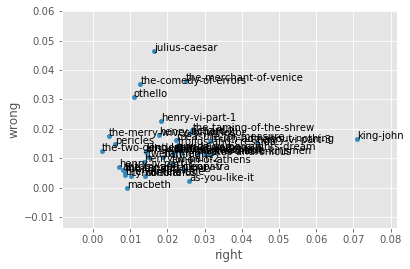

In [5]:
ax = df_norm.plot.scatter(x='right', y='wrong')

for i, txt in enumerate(df_norm.index):
    ax.annotate(txt, (df_norm['right'].iat[i],df_norm['wrong'].iat[i]))

Or without labels, to make it more readable:

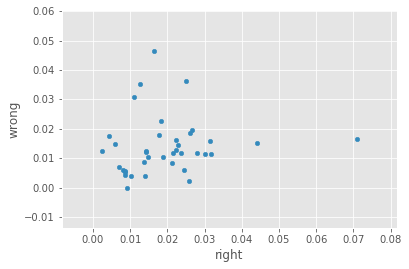

In [6]:
df_norm.plot.scatter(x='right', y='wrong')

Looking at the texts in terms of just two words, "right" and "wrong," we can see that there's clearly some difference in how plays deploy certain vocabulary. (*King John* has a lot of "right," while *Julius Caesar* has a lot of "wrong.") But we can't really tell from these two words alone if plays are falling into distinct groups.

Statistical modeling gives us a set of methods that can look at all dimensions or features at once and make a determination about categories or patterns in the data. In this case, we might use models to see if we can correctly place plays into their genres based on word counts.

## Unsupervised Clustering

Now that we have our matrix of word counts, there are many, many methods and techniques we could apply to categorize or *classify* our texts. There are two general types of modeling I will introduce: *unsupervised* methods and *supervised* ones. Supervised methods are so called because the investigator provides some labels to the data about which samples belong in which categories, and based on those examples---the *training data*---the computer tries to determine to which categories the unlabeled examples belong.

The supervised methods are what's most often meant by "machine learning" (because the machine "learns" based on the training data). But there are a set of *unsupervised* methods which try to find categories in data without knowing about categories in advance. We'll work with one such *clustering* method, K-Means Clustering. The k-means method attempts to find categories in data based on how close the samples are to one another in Cartesian space, i.e. in the graph above but across thousands of dimensions. 

The *k* in k-means stands for *any number*: we need to tell the computer how many clusters we think it should find. We know that Shakespeare plays can be sorted into roughly four categories---comedy, tragedy, history, and tragicomedy or romance---so we'll set `n_clusters` to 4.

In [7]:
kmeans = KMeans(n_clusters=4, random_state=42) # Create a KMeans instance that will look for 4 clusters
kmeans.fit(norm_features) # Feed in our normalized data

# Show which plays the model put together
kmeans_groups = defaultdict(list)
for k,v in zip(kmeans.labels_,filenames):
    kmeans_groups[k].append(v)
    
for v in kmeans_groups.values():
    print(v)

['coriolanus', 'julius-caesar', 'antony-and-cleopatra', 'troilus-and-cressida', 'the-winters-tale', 'timon-of-athens', 'the-merchant-of-venice', 'macbeth', 'the-two-noble-kinsmen', 'the-tempest', 'pericles', 'othello', 'a-midsummer-nights-dream', 'king-lear', 'cymbeline', 'titus-andronicus', 'romeo-and-juliet', 'alls-well-that-ends-well']
['loves-labors-lost', 'henry-viii', 'henry-v', 'king-john', 'henry-vi-part-1', 'hamlet', 'richard-ii', 'richard-iii', 'henry-vi-part-2', 'henry-vi-part-3']
['henry-iv-part-2', 'henry-iv-part-1', 'much-ado-about-nothing']
['as-you-like-it', 'the-merry-wives-of-windsor', 'the-taming-of-the-shrew', 'twelfth-night', 'the-two-gentlemen-of-verona', 'the-comedy-of-errors', 'measure-for-measure']


How did our unsupervised clustering method do? I think we might categorize this effort as *good* but not *great*. Most of the histories are together in one cluster, and a lot of the big comedies are in another cluster. The other two clusters are a bit of a mishmash. Most of the tragedies are together, but they're mixed in with other comedies, and there's no distinct cluster for romances/tragecomedies.

The next question is: would the computer do a better job if we tried to teach it about the genres we already know? To answer that, we'll need a *supervised classification* method.

## Targets

Before we can begin using a supervised method, we need to add one more piece of data to our matrix. In addition to *samples* and *features*, matrices can also have *targets*, that is labels for categories that particular samples fall into. These targets can be used to *train* a model by telling it what to expect.

In this case, we need targets that label the genre of a play. Rather than assigning genre labels myself, I pulled targets from the [Visualizing English Print](https://graphics.cs.wisc.edu/WP/vep/) (VEP) metadata. This data splits the plays into four categories: comedies (CO), tragedies (TR), histories (HI), and tragicomedies (TC). In the code below, I read in the VEP metadata and create a list of labels that matches the order of our list of plays.

In [8]:
def convert_title(title):
    title = title.lower().replace("'", "").replace(" ","-").replace("labours", "labors")
    if title.startswith('1') or title.startswith('2') or title.startswith('3'):
        title = f"{title[2:]}-part-{title[0]}"
    return title

with open('shakespeare/Shx_VEP.csv', 'r') as metafile:
    reader = csv.DictReader(metafile)
    genre_by_title = {convert_title(r['shortTitle']): r['Genre'] for r in reader}
    
genre = [genre_by_title[f] for f in filenames]
print(genre)

['TR', 'TR', 'CO', 'TR', 'HI', 'HI', 'TR', 'CO', 'HI', 'TR', 'CO', 'HI', 'HI', 'TR', 'TC', 'CO', 'CO', 'CO', 'CO', 'TC', 'TR', 'TR', 'CO', 'TR', 'CO', 'TR', 'CO', 'CO', 'HI', 'HI', 'CO', 'TR', 'TR', 'HI', 'HI', 'CO', 'HI', 'CO']


## Supervised Classification

Now that we have target labels, we can use them to train a *supervised model* to determine genre categories. Unlike with K-means clustering, where we simply create a model and plug in the entire dataset, we need to split our data into a *training set*, which we use to help our model learn, and a *test set*, which we use to see how the model did. In our case, we'll split our data approximately in half, using just over half of the plays for training and reserving the rest for testing. 

We need to split both the feature set (denoted by a capital X) and the target labels (denoted by a lowercase y). Luckily, scikit-learn does all of this for us with its `train_test_split()` function.

Once the data is split, we can choose a model to train. In this case, the method I've chosen is logistic regression, the same method that Ted Underwood uses in *Distant Horizons*. Logistic regression is quite an old method for classification, and it is useful in part because it is easy to explain and provides results that (as we shall see) are easier to interpret than newer methods like neural networks. Logistic regression essentially uses a logistic function to draw an s-shaped [sigmoid curve](https://en.wikipedia.org/wiki/Sigmoid_function) that takes any value and converts it to a value between 0 and 1. The closer the value is to 0 or 1, the more closely it belongs in one category or another. Because of this 0-or-1 one-or-the-other feature, logistic regression was originally only a *binary* classifier: it could only tell if something was in one of just two categories. However, we can use multiclass logistic regression, and the model will predict all four of our classes at once.

In the code below, I split the data automatically, create a logistic regression model, and "fit" that model using the training data. Then, I run the model to *predict* categories for the texts in the test set. In the end, I can get accuracy scores, as well as a list of the plays in the test set with their real and predicted genres.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_norm, genre, test_size=0.45, random_state=42)
lr = LogisticRegression(random_state=0, solver='lbfgs', penalty='none')
clf = lr.fit(X_train, y_train)

y_pred = clf.predict(X_test)
# evaluate accuracy
print("Accuracy score:", accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))
print("Cross validation score:", np.mean(cross_val_score(lr, norm_features, genre, cv=2)))
print()
print("Results of this run:\n")
print("Play Title | Actual Genre | Predicted Genre")
for title, real, predicted in zip(X_test.index, y_test, y_pred):
    print(f"{title} | {real} | {predicted}")


Accuracy score: 0.7222222222222222
Cross validation score: 0.7368421052631579

Results of this run:

Play Title | Actual Genre | Predicted Genre
henry-iv-part-1 | HI | CO
henry-vi-part-3 | HI | HI
henry-viii | HI | HI
macbeth | TR | TR
measure-for-measure | CO | CO
the-two-gentlemen-of-verona | CO | CO
troilus-and-cressida | TR | TR
the-comedy-of-errors | CO | CO
twelfth-night | CO | CO
as-you-like-it | CO | CO
the-tempest | CO | TR
king-john | HI | HI
the-merry-wives-of-windsor | CO | CO
henry-iv-part-2 | HI | CO
pericles | TC | TR
timon-of-athens | TR | TR
romeo-and-juliet | TR | CO
coriolanus | TR | TR


The results above show us a few things about how the logistic regression model did. First, the *accuracy score* shows the percentage of texts in the test set that were labeled correctly in this run of the model. 72% accuracy is not too bad!

However, this is only the accuracy result for the data split in just one way and run just once. How does the model do if we split up the data differently? The *cross validation score* answers this question by running the model several times with differently split data. The average of the accuracy of those runs gives us a sense of how well the model does no matter how the data is split. We can see that the cross validation shows that this particular run of the model is fairly close to the expected result.

And the results themselves show that the model got things mostly right. What's more, some of the things it got wrong were *interestingly* wrong. *Henry IV Parts 1 & 2*, history plays with long comic Falstaff scenes, were "incorrectly" labeled as comedies. *Romeo and Juliet*, a play that has a comedic structure up until its final tragic twist, was also labeled a comedy. *The Tempest*, one of Shakespeare's later romances that has both comic and tragic scenes, was listed as a comedy in our original data but labeled a tragedy by the model.

We can also assess a model's accuracy using a *confusion matrix*, a chart that shows how often predicted values matched expected values. In the code below I generate the confusion matrix for our model:

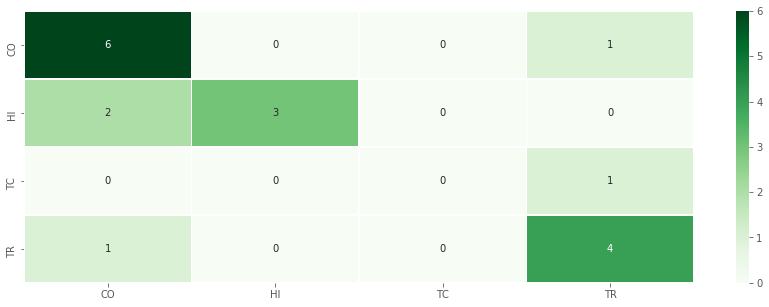

In [10]:
cm = confusion_matrix(y_test,y_pred)
cm_df = pd.DataFrame(cm, columns=clf.classes_, index=clf.classes_)
f, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(cm_df,annot=True,cmap='Greens',linewidths=.5)

In this confusion matrix, predicted values (the output of the model) are shown horizontally and expected values (what was in the original data) are shown vertically. When the two match, we can see the number of *true positives*, places where the predicted value matched the expected value. Those are the darkest squares along the diagonal from top left to bottom right. Our model got comedies right 6 times, histories right 3 times, and tragedies right 4 times. Not bad considering there were only 18 plays total in the test set!

The confusion matrix also shows false results---places where the predicted value did not match the expected value. Like we saw in the list above, the model miscategorized two histories as comedies and one tragicomedy as a tragedy, for example.

## Interpreting Results

So we know the logistic regression model performed reasonably well. It identifies the correct genre of a play in most cases, and when it doesn't there's usually an interesting (literary) reason why. Now that we have the model, we could plug in a new Shakespeare play, and the model could tell us its genre!

Wait a second---there are no new Shakespeare plays (he's been dead for some time), and a literary scholar can simply read a play to determine the genre. The truth is, we don't need a model to tell us a play's genre, especially the genre of any Shakespeare plays, which have been a matter of scholarly interest and debate for centuries. So if we don't need a model to predict the genre, then what is the model *for*?

For Facebook or FiveThirtyEight, models might be useful because of what they predict. In fact, large companies like Google often don't care how they arrived at a classifier, so long as they can use that classifier to serve ads or do whatever they're trying to do. But digital humanities scholars don't usually need computers to perform tasks for them, instead they're using the computer to help them understand something better. 

Way back at the beginning of this tutorial, we started by counting the words in each play. We did that because of an instinct that the vocabulary of the play is related to its genre. And based on the relative success of our model, there does seem to be such a relationship. But what's the nature of that relationship? What do wordcounts have to do with genre?

This gets back to why we used logistic regression over other approaches. As a model it's interpretable because it provides *coefficients* for each feature. That is, it doesn't just tell us the answer: logistic regression tells us how it arrived at the answer. For each possible genre class, the model gives us a coefficient for every feature, every word. The coefficient is either a positive or negative number. If the coefficient is a high positive number, that means it's a strong positive indicator that a text will belong in that class: if that word appears a lot in the play, the model will be more likely to assign the play to that genre. If the coefficient is a low negative number, that means it's a strong negative indicator: if that word appears a lot in the play, the model will be more likely **not** to assign the play to that genre.

In the code below, I show the top 5 highest and lowest coefficients for each class. This gives us a sense of what words drove the model's genre predictions.

In [11]:
for g,c in zip(clf.classes_, clf.coef_):
    print("Genre:", g)
    sort_values = sorted(list(zip(vectorizer.get_feature_names(), c)), key = lambda x: x[1], reverse=True)
    print("Best positive indicators (words with highest coefficients):")
    for s in sort_values[:5]:
        print("\t", s)
    print("Best negative indicators (words with lowest coefficients):")
    for s in sort_values[-5:]:
        print("\t", s)
    print()

Genre: CO
Best positive indicators (words with highest coefficients):
	 ('love', 14.31353413344846)
	 ('son', 14.288996455277514)
	 ('sir', 13.826512853008708)
	 ('prince', 10.989743814876732)
	 ('sweet', 8.775287101685953)
Best negative indicators (words with lowest coefficients):
	 ('let', -6.5742804071516785)
	 ('noble', -8.210848867991874)
	 ('th', -9.775218786022753)
	 ('queen', -12.782344540946523)
	 ('thy', -13.495860197542175)

Genre: HI
Best positive indicators (words with highest coefficients):
	 ('king', 28.729068957896786)
	 ('thy', 13.404769720173682)
	 ('duke', 12.274762205125416)
	 ('god', 11.233728402247833)
	 ('queen', 8.381486461205936)
Best negative indicators (words with lowest coefficients):
	 ('come', -7.667322357222622)
	 ('love', -9.337678472130184)
	 ('know', -9.41381214695534)
	 ('th', -10.148492273110667)
	 ('sir', -14.334972078255046)

Genre: TC
Best positive indicators (words with highest coefficients):
	 ('daughter', 16.561641338907688)
	 ('th', 12.2896191

If you're familiar with the genres of early modern drama, this is a pretty exciting list. "Love" is the strongest indicator for comedy, a genre almost always organized around marriage. Words for high social ranks---"king," "queen," "duke," even "god"---are strongly indicative of the monarch-obsessed history plays. Not everything is perfectly clear. The positive indicators for tragedy aren't thematic or character based, but the negative indicators for tragedy match the positive ones for comedy and tragicomedy. (Perhaps, for our model, a tragedy is a thing that's not a comedy.) But overall, this list conforms with some scholarly assumptions about certain Shakespearean genres, and it invites the curious scholar into more close reading, e.g. what is it about the word "let" that indicates tragedy so well?

For a humanist scholar, models are less about *prediction* and more about the *features* themselves. A little knowledge about how various models work can go a long way. Using statistical modeling, we can begin to determine the relationship between certain sets of features and different historical categories and classifications. Beyond word counts, modeling allows scholars to explore all sorts of features and can be a powerful tool for framing questions for future research.